In [1]:
HQA_IMAGENET_SAVE_PATH="./checkpoints/hqa_imagenet.pt"
CLASSIFIER_IMAGENET_SAVE_PATH = './checkpoints/resnet_imagenet.pt'

In [2]:
import torch
import torchattacks
from torchvision.transforms import ToPILImage
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import lightning.pytorch as pl

import os

from hqa_lightning import train_hqa_imagenet100, HQA2D_Lightning
from resnet50 import ResNet50
from data import get_imagenet_dataloaders, get_preds
from ImageNet100 import ImageNet100




device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
dl_train, dl_test = get_imagenet_dataloaders()

Device:  cuda


In [3]:
if os.path.exists(HQA_IMAGENET_SAVE_PATH):
    hqa_model = torch.load(HQA_IMAGENET_SAVE_PATH).to(device)
    print(f"Loaded {len(hqa_model)} layer model from checkpoint.")
else:
    hqa_model = train_hqa_imagenet100(max_epochs=50, devices=1)
    torch.save(hqa_model, HQA_IMAGENET_SAVE_PATH)

def reconstruct(layer, attack=None):
    def _reconstruct(x, y):
        if attack is not None:
            x = attack(x, y)
        if layer >= 0:
            x = x.to(hqa_model.device)
            x_recon = hqa_model[layer].reconstruct(x)
            return x_recon
        return x
    return _reconstruct

Loaded 5 layer model from checkpoint.


In [4]:
if os.path.exists(CLASSIFIER_IMAGENET_SAVE_PATH):
    resnet_model = torch.load(CLASSIFIER_IMAGENET_SAVE_PATH).to(device)
    print(f"Loaded ImageNet100 classifier from checkpoint.")
else:
    print("Classifier checkpoint not found!")

Loaded ImageNet100 classifier from checkpoint.


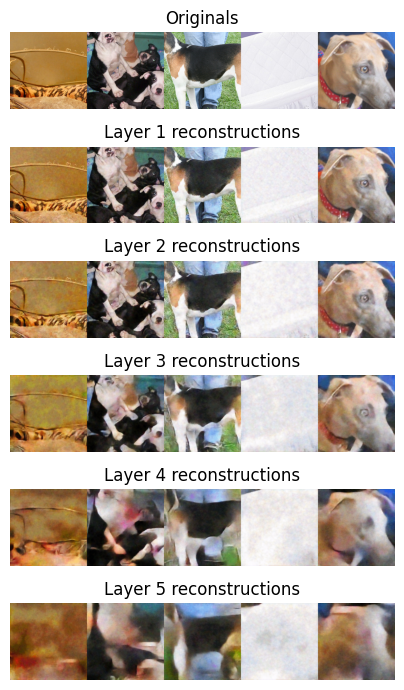

In [5]:
num_recons = 5

toImage = ToPILImage()

x, _ = next(iter(dl_test))
x = x[:num_recons]

originals = np.concatenate([toImage(img) for img in x], axis=1)
fig, ax = plt.subplots(ncols=1, nrows=len(hqa_model) + 1, figsize=(5,7))
ax[0].imshow(originals)
ax[0].axis("off")
ax[0].set_title("Originals")

for layer_index, layer in enumerate(hqa_model):
    x = x.to(hqa_model.device)
    recons = layer.reconstruct(x)
    recons = recons.cpu()
    recons_img = np.concatenate([toImage(recon) for recon in recons], axis=1)
    ax[layer_index + 1].imshow(recons_img)
    ax[layer_index+ 1].axis("off")
    ax[layer_index + 1].set_title(f"Layer {layer_index+1} reconstructions")

fig.tight_layout()
plt.show()



In [6]:
accuracies_no_attack = []

Y, Y_pred = get_preds(resnet_model, dl_test)
accuracy = accuracy_score(Y,Y_pred)
print("Original Data Classification Accuracy: ", accuracy)
accuracies_no_attack.append(accuracy)

for index, layer in enumerate(hqa_model):
    Y, Y_pred = get_preds(resnet_model, dl_test, transform=reconstruct(index))
    accuracy = accuracy_score(Y,Y_pred)
    accuracies_no_attack.append(accuracy)
    print(f"Layer {index} Reconstructions Classification Accuracy: ", accuracy)

Original Data Classification Accuracy:  0.856
Layer 0 Reconstructions Classification Accuracy:  0.8254
Layer 1 Reconstructions Classification Accuracy:  0.7264
Layer 2 Reconstructions Classification Accuracy:  0.3592
Layer 3 Reconstructions Classification Accuracy:  0.089
Layer 4 Reconstructions Classification Accuracy:  0.0314


In [ ]:
accuracies_fgsm_attack_01 = []
accuracies_fgsm_attack_05 = []
accuracies_fgsm_attack_07 = []
accuracies_fgsm_attack_10 = []
accuracies_fgsm_attack_20 = []

epsilons = [0.2, 0.01, 0.05, 0.07, 0.1]

eps_to_array = {
    0.01 : accuracies_fgsm_attack_01,
    0.05 : accuracies_fgsm_attack_05,
    0.07 : accuracies_fgsm_attack_07,
    0.1 : accuracies_fgsm_attack_10,
    0.2 : accuracies_fgsm_attack_20
}

for epsilon in epsilons:
    attack = torchattacks.FGSM(resnet_model, eps=epsilon)
    Y, Y_pred = get_preds(resnet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [FGSM eps={epsilon}] Accuracy: ", accuracy)
    eps_to_array[epsilon].append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(resnet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        eps_to_array[epsilon].append(accuracy)
        print(f"Layer {index} Reconstructions [FGSM eps={epsilon}] Accuracy: ", accuracy)

Attack [FGSM eps=0.2] Accuracy:  0.3684
Layer 0 Reconstructions [FGSM eps=0.2] Accuracy:  0.4114
Layer 1 Reconstructions [FGSM eps=0.2] Accuracy:  0.3666
Layer 2 Reconstructions [FGSM eps=0.2] Accuracy:  0.1562
Layer 3 Reconstructions [FGSM eps=0.2] Accuracy:  0.0438
Layer 4 Reconstructions [FGSM eps=0.2] Accuracy:  0.0268
Attack [FGSM eps=0.01] Accuracy:  0.433
Layer 0 Reconstructions [FGSM eps=0.01] Accuracy:  0.7628
Layer 1 Reconstructions [FGSM eps=0.01] Accuracy:  0.708
Layer 2 Reconstructions [FGSM eps=0.01] Accuracy:  0.3574


In [ ]:
print(accuracies_no_attack)
print(accuracies_fgsm_attack_01)
print(accuracies_fgsm_attack_05)
print(accuracies_fgsm_attack_07)
print(accuracies_fgsm_attack_10)
print(accuracies_fgsm_attack_20)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_fgsm_attack_01, label="FGSM eps=0.01")
plt.plot(layers, accuracies_fgsm_attack_05, label="FGSM eps=0.05")
plt.plot(layers, accuracies_fgsm_attack_07, label="FGSM eps=0.07")
plt.plot(layers, accuracies_fgsm_attack_10, label="FGSM eps=0.1")
plt.plot(layers, accuracies_fgsm_attack_20, label="FGSM eps=0.2")

plt.title("Classification Accuracy of FGSM Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.legend()
plt.savefig("./resources/imagenet_fgsm_reconstructions.png")
plt.show()

# Visualize Attacked Examples

In [ ]:
num_recons = 5

toImage = ToPILImage()
dataset = dl_test.dataset

epsilons = [0.01, 0.05, 0.07, 0.1, 0.2]

# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(epsilons) + 1, ncols=1, constrained_layout=True, figsize=(15,20))
fig.suptitle('ImageNet FGSM Adversarial Examples')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=5)
    if row == 0:
        subfig.suptitle(f'Originals (No Attack)')
        y_pred = resnet_model(x.to(resnet_model.device))[:num_recons]
        y_pred = y_pred.argmax(axis=1)
        class_folders = [dataset.classes[index] for index in y_pred]
        class_names = list(map(lambda folder: dataset.get_human_readable_class(folder), class_folders))
        for ndx, x_original in enumerate(x[:num_recons]):
            axis = axs[ndx]
            original_img = toImage(x_original)
            axis.get_yaxis().set_ticks([])
            axis.get_xaxis().set_ticks([])
            axis.imshow(original_img)
            axis.set_xlabel(class_names[ndx])
    else:
        epsilon = epsilons[row - 1]
        subfig.suptitle(f'FGSM Adversarial Examples (ε={epsilon})')
        attack = torchattacks.FGSM(resnet_model, eps=epsilon)
        attacked_x = attack(x,y)
        attacked_y_pred = resnet_model(attacked_x.to(resnet_model.device))[:num_recons]
        attacked_y_pred = attacked_y_pred.argmax(axis=1)
        attacked_class_folders = [dataset.classes[index] for index in attacked_y_pred]
        attacked_class_names = list(map(lambda folder: dataset.get_human_readable_class(folder), attacked_class_folders))
        for img_ndx, x_attacked in enumerate(attacked_x[:num_recons]):
            axis = axs[img_ndx]
            attacked_img = toImage(x_attacked)
            axis.get_yaxis().set_ticks([])
            axis.get_xaxis().set_ticks([])
            axis.imshow(attacked_img)
            axis.set_xlabel(attacked_class_names[img_ndx])
plt.savefig("resources/imagenet_fgsm.png")
plt.show()